# HypotheSAEs Correlation Analysis
# This notebook demonstrates neuron training and correlation analysis without annotation/fidelity scoring

This notebook focuses on:
- Training configurable number of SAEs
- Computing target correlations 
- Interpreting neurons without fidelity scoring
- Displaying and saving datasets

In [ ]:
%load_ext autoreload
%autoreload 2

import os
os.environ['OPENAI_KEY_SAE'] = ''
import torch
import numpy as np
import pandas as pd
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import seaborn as sns
import umap
from sklearn.preprocessing import StandardScaler

from hypothesaes.quickstart import train_sae, interpret_sae
from hypothesaes.embedding import get_openai_embeddings, get_local_embeddings
from hypothesaes.sae import get_multiple_sae_activations
from hypothesaes.select_neurons import select_neurons_correlation

# Set plotting style
plt.style.use('default')
sns.set_palette("viridis")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

Using device: mps


## Configuration
Set the number of SAEs to train and neurons to interpret

In [2]:
# Configuration parameters
NUM_SAES = 3  # Number of SAEs to train
TOTAL_NEURONS_TO_INTERPRET = 150  # Total neurons across all SAEs
TOP_NEURONS = 50  # Top correlation neurons to show
BOTTOM_NEURONS = 30  # Bottom correlation neurons to show
RANDOM_NEURONS = 70  # Additional random neurons (TOTAL - TOP - BOTTOM)

# SAE configurations (M, K pairs)
SAE_CONFIGS = [
    (256, 8),
    (128, 6),
    (64, 4),
    (32, 4)
][:NUM_SAES]  # Take only the number we want to train

## Load and Display Data
Load the dataset and show some basic statistics

In [3]:
current_dir = os.getcwd()
if current_dir.endswith("notebooks"):
    prefix = "../"
else:
    prefix = "./"

base_dir = os.path.join(prefix, "demo-data")
train_df = pd.read_csv(os.path.join(base_dir, "reddit-depression-train.csv"))
val_df = pd.read_csv(os.path.join(base_dir, "reddit-depression-test.csv"))

texts = train_df['text'].tolist()
labels = train_df['label'].values
val_texts = val_df['text'].tolist()

# print(f"Training set: {len(texts)} reviews")
# print(f"Validation set: {len(val_texts)} reviews")
# print(f"\nTarget variable (stars) distribution:")
# print(train_df['stars'].value_counts().sort_index())
# print(f"\nMean rating: {labels.mean():.2f}")
# print(f"Standard deviation: {labels.std():.2f}")

# Display sample reviews
# print("\n=== Sample Reviews ===")
# for i in range(3):
#     print(f"\nReview {i+1} (Rating: {labels[i]} stars):")
#     print(f"{texts[i][:200]}...")

# # Display the dataset
# print("\n=== Dataset Overview ===")
# display(train_df.head())
# print(f"\nDataset info:")
# print(train_df.info())

## Compute Text Embeddings
Generate embeddings with caching support

In [4]:
EMBEDDER = "text-embedding-3-small"  # OpenAI
# EMBEDDER = "nomic-ai/modernbert-embed-base"  # Huggingface model, will run locally
CACHE_NAME = f"Multiple_SAEs_depression{EMBEDDER}"

print(f"Computing embeddings using {EMBEDDER}...")
print(f"Cache name: {CACHE_NAME}")

text2embedding = get_openai_embeddings(texts + val_texts, model=EMBEDDER, cache_name=CACHE_NAME)
# text2embedding = get_local_embeddings(texts + val_texts, model=EMBEDDER, batch_size=128, cache_name=CACHE_NAME)

train_embeddings = np.stack([text2embedding[text] for text in texts])
val_embeddings = np.stack([text2embedding[text] for text in val_texts])

print(f"Training embeddings shape: {train_embeddings.shape}")
print(f"Validation embeddings shape: {val_embeddings.shape}")

Computing embeddings using text-embedding-3-small...
Cache name: Multiple_SAEs_depressiontext-embedding-3-small


Processing chunks:   0%|          | 0/1 [00:00<?, ?it/s]

Chunk 0:   0%|          | 0/30 [00:00<?, ?it/s]

Saved 7581 embeddings to /Users/ivanculo/Desktop/Projects/SAEs/HypotheSAEs/emb_cache/Multiple_SAEs_depressiontext-embedding-3-small/chunk_000.npy
Training embeddings shape: (6128, 1536)
Validation embeddings shape: (1534, 1536)


## Train SAEs
Train multiple SAEs with different configurations

In [5]:
checkpoint_dir = os.path.join(prefix, "checkpoints", CACHE_NAME)
sae_list = []

print(f"Training {NUM_SAES} SAEs with configurations: {SAE_CONFIGS}")

for i, (M, K) in enumerate(SAE_CONFIGS):
    print(f"\n=== Training SAE {i+1}/{NUM_SAES}: M={M}, K={K} ===")
    sae = train_sae(
        embeddings=train_embeddings, 
        M=M, 
        K=K, 
        checkpoint_dir=checkpoint_dir, 
        val_embeddings=val_embeddings
    )
    sae_list.append(sae)
    print(f"SAE {i+1} trained successfully")

print(f"\n✓ All {len(sae_list)} SAEs trained successfully!")

Training 3 SAEs with configurations: [(256, 8), (128, 6), (64, 4)]

=== Training SAE 1/3: M=256, K=8 ===


  0%|          | 0/100 [00:00<?, ?it/s]

Saved model to ../checkpoints/Multiple_SAEs_depressiontext-embedding-3-small/SAE_M=256_K=8.pt
SAE 1 trained successfully

=== Training SAE 2/3: M=128, K=6 ===


  0%|          | 0/100 [00:00<?, ?it/s]

Early stopping triggered after 77 epochs
Saved model to ../checkpoints/Multiple_SAEs_depressiontext-embedding-3-small/SAE_M=128_K=6.pt
SAE 2 trained successfully

=== Training SAE 3/3: M=64, K=4 ===


  0%|          | 0/100 [00:00<?, ?it/s]

Early stopping triggered after 72 epochs
Saved model to ../checkpoints/Multiple_SAEs_depressiontext-embedding-3-small/SAE_M=64_K=4.pt
SAE 3 trained successfully

✓ All 3 SAEs trained successfully!


## Compute SAE Activations and Target Correlations
Calculate neuron activations and their correlation with the target variable

In [7]:
print("Computing SAE activations...")
activations = get_multiple_sae_activations(sae_list, train_embeddings)
print(f"Activations shape: {activations.shape}")

print("\nComputing correlations with target variable...")
correlations = []
neuron_info = []

neuron_idx = 0
for sae_idx, sae in enumerate(sae_list):
    M, K = SAE_CONFIGS[sae_idx]
    sae_neurons = activations[:, neuron_idx:neuron_idx + M]
    
    for local_neuron_idx in range(M):
        neuron_activations = sae_neurons[:, local_neuron_idx]
        correlation, p_value = pearsonr(neuron_activations, labels)
        
        correlations.append(correlation)
        neuron_info.append({
            'global_neuron_idx': neuron_idx + local_neuron_idx,
            'local_neuron_idx': local_neuron_idx,
            'sae_idx': sae_idx,
            'sae_config': (M, K),
            'correlation': correlation,
            'p_value': p_value,
            'abs_correlation': abs(correlation)
        })
    
    neuron_idx += M

# Create DataFrame with correlation results
correlation_df = pd.DataFrame(neuron_info)
correlation_df = correlation_df.sort_values('abs_correlation', ascending=False)

print(f"\n=== Correlation Statistics ===")
print(f"Total neurons: {len(correlations)}")
print(f"Mean correlation: {np.mean(correlations):.4f}")
print(f"Std correlation: {np.std(correlations):.4f}")
print(f"Max correlation: {np.max(correlations):.4f}")
print(f"Min correlation: {np.min(correlations):.4f}")

print(f"\n=== Top 10 Correlations ===")
display(correlation_df.head(10))

Computing SAE activations...


Computing activations (batchsize=16384):   0%|          | 0/1 [00:00<?, ?it/s]

Computing activations (batchsize=16384):   0%|          | 0/1 [00:00<?, ?it/s]

Computing activations (batchsize=16384):   0%|          | 0/1 [00:00<?, ?it/s]

Activations shape: (6128, 448)

Computing correlations with target variable...

=== Correlation Statistics ===
Total neurons: 448
Mean correlation: -0.0112
Std correlation: 0.1246
Max correlation: 0.3768
Min correlation: -0.2783

=== Top 10 Correlations ===


,global_neuron_idx,local_neuron_idx,sae_idx,sae_config,correlation,p_value,abs_correlation
327,327,71,1,"(128, 6)",0.376820,5.172341e-206,0.376820
423,423,39,2,"(64, 4)",0.366796,1.707552e-194,0.366796
438,438,54,2,"(64, 4)",0.342686,1.979810e-168,0.342686
302,302,46,1,"(128, 6)",0.340566,3.030357e-166,0.340566
88,88,88,0,"(256, 8)",0.336277,7.050321e-162,0.336277
429,429,45,2,"(64, 4)",0.331898,1.716751e-157,0.331898
266,266,10,1,"(128, 6)",0.328464,4.212442e-154,0.328464
55,55,55,0,"(256, 8)",0.321795,1.215486e-147,0.321795
440,440,56,2,"(64, 4)",0.297282,2.815059e-125,0.297282
392,392,8,2,"(64, 4)",-0.278342,1.958036e-109,0.278342


## Select and Interpret Neurons
Select top, bottom, and random neurons for interpretation

In [8]:
# Select neurons to interpret
top_neurons = correlation_df.head(TOP_NEURONS)['global_neuron_idx'].tolist()
bottom_neurons = correlation_df.tail(BOTTOM_NEURONS)['global_neuron_idx'].tolist()

# Select random neurons (excluding top and bottom)
remaining_neurons = correlation_df.iloc[TOP_NEURONS:-BOTTOM_NEURONS]['global_neuron_idx'].tolist()
random_neurons = np.random.choice(remaining_neurons, size=min(RANDOM_NEURONS, len(remaining_neurons)), replace=False).tolist()

selected_neurons = top_neurons + bottom_neurons + random_neurons
selected_neurons = sorted(list(set(selected_neurons)))  # Remove duplicates and sort

print(f"Selected {len(selected_neurons)} neurons for interpretation:")
print(f"- Top {TOP_NEURONS} (highest absolute correlation)")
print(f"- Bottom {BOTTOM_NEURONS} (lowest absolute correlation)")
print(f"- Random {len(random_neurons)} (from middle range)")

# Create neuron selection info
neuron_selection_info = []
for neuron_idx in selected_neurons:
    neuron_data = correlation_df[correlation_df['global_neuron_idx'] == neuron_idx].iloc[0]
    if neuron_idx in top_neurons:
        selection_type = "top"
    elif neuron_idx in bottom_neurons:
        selection_type = "bottom"
    else:
        selection_type = "random"
    
    neuron_selection_info.append({
        'neuron_idx': neuron_idx,
        'selection_type': selection_type,
        'correlation': neuron_data['correlation'],
        'sae_config': neuron_data['sae_config']
    })

selection_df = pd.DataFrame(neuron_selection_info)
print(f"\n=== Selected Neurons Overview ===")
display(selection_df.sort_values('correlation', ascending=False))

Selected 150 neurons for interpretation:
- Top 50 (highest absolute correlation)
- Bottom 30 (lowest absolute correlation)
- Random 70 (from middle range)

=== Selected Neurons Overview ===


,neuron_idx,selection_type,correlation,sae_config
100,327,top,0.376820,"(128, 6)"
140,423,top,0.366796,"(64, 4)"
147,438,top,0.342686,"(64, 4)"
92,302,top,0.340566,"(128, 6)"
30,88,top,0.336277,"(256, 8)"
...,...,...,...,...
149,444,top,-0.216518,"(64, 4)"
126,396,top,-0.217988,"(64, 4)"
135,411,top,-0.225685,"(64, 4)"
130,402,top,-0.241762,"(64, 4)"


## Task-Specific Instructions for Interpretation

In [9]:
TASK_SPECIFIC_INSTRUCTIONS = """
All texts are expressions of psychological patterns and mental states. Your task is to identify and describe features that capture HOW people think, feel, relate, and cope, rather than just WHAT they think about. Focus on therapeutic and psychological processes such as:

- **Cognitive patterns**: Information processing styles (analytical vs. intuitive, systematic vs. scattered), reasoning approaches (logical, emotional, biased, flexible), metacognitive awareness (self-reflection, insight into one's own thinking)

- **Emotional regulation patterns**: Coping mechanisms (adaptive vs. maladaptive), emotional expression and management, stress responses, defense mechanisms (denial, projection, rationalization)

- **Attachment and relational patterns**: Trust and intimacy indicators, boundary setting, interpersonal dynamics, dependency vs. autonomy, communication styles in relationships

- **Self-concept and identity patterns**: Self-talk patterns (self-compassionate vs. self-critical), identity coherence, self-efficacy beliefs, shame vs. guilt expressions, self-worth indicators

- **Behavioral and motivational patterns**: Approach vs. avoidance tendencies, goal-setting and persistence, locus of control (internal vs. external), agency and empowerment indicators

- **Trauma and stress responses**: Hypervigilance markers, dissociation indicators, intrusive thought patterns, avoidance behaviors, resilience factors

- **Cognitive distortions and biases**: All-or-nothing thinking, catastrophizing, mind reading, personalization, overgeneralization

- **Therapeutic process indicators**: Insight development, resistance patterns, therapeutic alliance markers, readiness for change, integration of experiences

Features should be formulated as descriptive statements that explain the psychological mechanism being expressed through language patterns, word choice, emotional tone, narrative structure, and thematic content.

Examples:
- "demonstrates emotion regulation through measured language that contains intense feelings within structured expression"
- "exhibits anxious attachment through excessive reassurance-seeking and fear of abandonment themes"
- "shows cognitive flexibility in trauma processing by holding multiple perspectives on the same difficult experience"
- "manifests self-critical internal voice through persistent negative self-attribution and minimization of achievements"
- "reveals avoidance coping through deflection to external topics when approaching emotionally charged material"
"""

## Interpret Selected Neurons
Generate interpretations for the selected neurons without fidelity scoring

In [14]:


print(f"Interpreting {len(selected_neurons)} selected neurons...")

# Interpret neurons without fidelity scoring
interpretations = interpret_sae(
    texts=texts,
    embeddings=train_embeddings,
    neuron_indices=selected_neurons,
    # n_candidate_interpretations=1,
    sae=sae_list,
    task_specific_instructions=TASK_SPECIFIC_INSTRUCTIONS,
    print_examples_n=3
)

print(f"\n✓ Generated interpretations for {len(interpretations)} neurons")

Interpreting 150 selected neurons...


Computing activations (batchsize=16384):   0%|          | 0/1 [00:00<?, ?it/s]

Computing activations (batchsize=16384):   0%|          | 0/1 [00:00<?, ?it/s]

Computing activations (batchsize=16384):   0%|          | 0/1 [00:00<?, ?it/s]

Activations shape: (6128, 448)


Generating 1 interpretation(s) per neuron:   0%|          | 0/150 [00:00<?, ?it/s]


Neuron 10 (from SAE M=256, K=8): expresses emotional overwhelm through repeated references to being unable to cope or continue, often using phrases like 'too much', 'can’t stand it', or 'wish it would end'

Top activating examples:
1. i m at that point it s just too much there s no way to even describe it anymore
2. i just don t know how much longer i can do this life is too much
3. it s so tiring to keep going i just can t stand it anymore i wish it all would end
----------------------------------------------------------------------------------------------------

Neuron 13 (from SAE M=256, K=8): expresses a sense of persistent internal struggle and self-awareness about mental health challenges, often seeking advice or solutions to cope or improve despite feelings of hopelessness

Top activating examples:
1. hi everyone i m new to this sub and am just seeking advice support this weekend i entered into a huge depressive episode after not having one for many month i struggle with depres

## Create Final Results Dataset
Combine correlation data with interpretations

In [21]:
print(interpretations.columns)

Index(['neuron_idx', 'source_sae', 'interpretation', 'top_example_1',
       'top_example_2', 'top_example_3'],
      dtype='object')


In [22]:
# Build results_data as before, but DO NOT include 'interpretation' in the dict
results_data = []

for neuron_idx in selected_neurons:
    # Get correlation info
    neuron_data = correlation_df[correlation_df['global_neuron_idx'] == neuron_idx].iloc[0]
    
    # Get selection info
    selection_data = selection_df[selection_df['neuron_idx'] == neuron_idx].iloc[0]
    
    results_data.append({
        'neuron_idx': neuron_idx,
        'local_neuron_idx': neuron_data['local_neuron_idx'],
        'sae_idx': neuron_data['sae_idx'],
        'sae_config_M': neuron_data['sae_config'][0],
        'sae_config_K': neuron_data['sae_config'][1],
        'target_correlation': neuron_data['correlation'],
        'abs_correlation': neuron_data['abs_correlation'],
        'p_value': neuron_data['p_value'],
        'selection_type': selection_data['selection_type'],
        # Do NOT include 'interpretation' here
    })

results_df = pd.DataFrame(results_data)
results_df = results_df.sort_values('abs_correlation', ascending=False)

# Merge with interpretations_df to add interpretation and top examples
results_df = results_df.merge(
    interpretations[['neuron_idx', 'interpretation', 'top_example_1', 'top_example_2', 'top_example_3']],
    on='neuron_idx',
    how='left'
)

# Optional: Fill missing interpretations with a default string
results_df['interpretation'] = results_df['interpretation'].fillna("No interpretation generated")

print("=== Final Results Dataset ===")
pd.set_option('display.max_colwidth', None)
display(results_df)
pd.reset_option('display.max_colwidth')

print(f"\n=== Summary Statistics ===")
print(f"Total interpreted neurons: {len(results_df)}")
print(f"Selection breakdown:")
print(results_df['selection_type'].value_counts())
print(f"\nCorrelation range: {results_df['target_correlation'].min():.4f} to {results_df['target_correlation'].max():.4f}")
print(f"Mean absolute correlation: {results_df['abs_correlation'].mean():.4f}")

=== Final Results Dataset ===


neuron_idx  local_neuron_idx  sae_idx  sae_config_M  sae_config_K  \
0           327                71        1           128             6   
1           423                39        2            64             4   
2           438                54        2            64             4   
3           302                46        1           128             6   
4            88                88        0           256             8   
..          ...               ...      ...           ...           ...   
145         166               166        0           256             8   
146         237               237        0           256             8   
147         224               224        0           256             8   
148         134               134        0           256             8   
149          85                85        0           256             8   

     target_correlation  abs_correlation        p_value selection_type  \
0              0.376820         0.376820  5.172341e-206            top   
1              0.366796         0.366796  1.707552e-194            top   
2              0.342686         0.342686  1.979810e-168            top   
3              0.340566         0.340566  3.030357e-166            top   
4              0.336277         0.336277  7.050321e-162            top   
..                  ...              ...            ...            ...   
145           -0.001726         0.001726   8.925334e-01         bottom   
146           -0.001193         0.001193   9.255902e-01         bottom   
147            0.001188         0.001188   9.258939e-01         bottom   
148            0.001109         0.001109   9.308408e-01         bottom   
149           -0.000051         0.000051   9.968404e-01         bottom   

                                                                                                                                                                         interpretation  \
0    expresses pervasive hopelessness and exhaustion through repeated themes of emptiness, lack of motivation, and feelings of being trapped in a meaningless or unchangeable situation   
1                                        expresses pervasive hopelessness and worthlessness through repetitive self-critical language and descriptions of life as inescapable suffering   
2     expresses deep emotional distress through detailed personal narratives of trauma, loss, and unresolved pain, often including self-reflection and a sense of hopelessness or guilt   
3                                                             uses the word 'depression' explicitly and repeatedly across varied contexts, often personifying or directly addressing it   
4                                                                    uses the term 'depression' in a casual, personified, or metaphorical manner, often as a recurring theme or subject   
..                                                                                                                                                                                  ...   
145                                                                            references religious or spiritual beliefs in the context of mental health struggles or coping mechanisms   
146              expresses physical tiredness explicitly through direct statements of fatigue, such as 'tired' or 'so tired', without elaborating on emotional or psychological reasons   
147  expresses psychological or emotional states through indirect or externalized references, often using humor, sarcasm, or cultural commentary to deflect direct emotional expression   
148          expresses personal or observed struggles with mental health conditions such as depression, anxiety, or trauma, often described with vivid emotional or experiential detail   
149                                                                                    expresses excessive self-blame and guilt through repeated apologies and self-critic


=== Summary Statistics ===
Total interpreted neurons: 150
Selection breakdown:
selection_type
random    70
top       50
bottom    30
Name: count, dtype: int64

Correlation range: -0.2783 to 0.3768
Mean absolute correlation: 0.1279


## Save Results
Save the dataset and results to files

In [25]:
# Create output directory
output_dir = os.path.join(prefix, "outputs", CACHE_NAME)
os.makedirs(output_dir, exist_ok=True)

# Save results dataset
results_csv_path = os.path.join(output_dir, "correlation_analysis_results.csv")
results_df.to_csv(results_csv_path, index=False)
print(f"✓ Saved results to: {results_csv_path}")

# Save full correlation data
correlation_csv_path = os.path.join(output_dir, "all_neuron_correlations.csv")
correlation_df.to_csv(correlation_csv_path, index=False)
print(f"✓ Saved all correlations to: {correlation_csv_path}")

# Save original dataset with some analysis
dataset_analysis = {
    'total_reviews': len(texts),
    'mean_rating': float(labels.mean()),
    'std_rating': float(labels.std()),
    'rating_distribution': train_df['label'].value_counts().to_dict(),
    'embedder_used': EMBEDDER,
    'cache_name': CACHE_NAME,
    'num_saes_trained': NUM_SAES,
    'sae_configs': SAE_CONFIGS,
    'total_neurons': len(correlations),
    'neurons_interpreted': len(selected_neurons),
    'max_correlation': float(np.max(correlations)),
    'min_correlation': float(np.min(correlations))
}

import json
analysis_json_path = os.path.join(output_dir, "dataset_analysis.json")
with open(analysis_json_path, 'w') as f:
    json.dump(dataset_analysis, f, indent=2)
print(f"✓ Saved dataset analysis to: {analysis_json_path}")

print(f"\n=== All outputs saved to: {output_dir} ===")
print(f"Files created:")
print(f"- correlation_analysis_results.csv (main results)")
print(f"- all_neuron_correlations.csv (all neuron correlations)")
print(f"- dataset_analysis.json (dataset and experiment metadata)")

✓ Saved results to: ../outputs/Multiple_SAEs_depressiontext-embedding-3-small/correlation_analysis_results.csv
✓ Saved all correlations to: ../outputs/Multiple_SAEs_depressiontext-embedding-3-small/all_neuron_correlations.csv
✓ Saved dataset analysis to: ../outputs/Multiple_SAEs_depressiontext-embedding-3-small/dataset_analysis.json

=== All outputs saved to: ../outputs/Multiple_SAEs_depressiontext-embedding-3-small ===
Files created:
- correlation_analysis_results.csv (main results)
- all_neuron_correlations.csv (all neuron correlations)
- dataset_analysis.json (dataset and experiment metadata)


In [26]:
print("=== TOP CORRELATIONS WITH INTERPRETATIONS ===")
print("\nMost positively correlated neurons (higher ratings):")
positive_results = results_df[results_df['target_correlation'] > 0].head(10)
for _, row in positive_results.iterrows():
    print(f"\nNeuron {row['neuron_idx']} (SAE {row['sae_config_M']}-{row['sae_config_K']})")
    print(f"Correlation: {row['target_correlation']:.4f}")
    print(f"Interpretation: {row['interpretation']}")
    print("-" * 80)

print("\n\nMost negatively correlated neurons (lower ratings):")
negative_results = results_df[results_df['target_correlation'] < 0].head(10)
for _, row in negative_results.iterrows():
    print(f"\nNeuron {row['neuron_idx']} (SAE {row['sae_config_M']}-{row['sae_config_K']})")
    print(f"Correlation: {row['target_correlation']:.4f}")
    print(f"Interpretation: {row['interpretation']}")
    print("-" * 80)

print(f"\n✓ Analysis complete! Results saved to {output_dir}")

=== TOP CORRELATIONS WITH INTERPRETATIONS ===

Most positively correlated neurons (higher ratings):

Neuron 327 (SAE 128-6)
Correlation: 0.3768
Interpretation: expresses pervasive hopelessness and exhaustion through repeated themes of emptiness, lack of motivation, and feelings of being trapped in a meaningless or unchangeable situation
--------------------------------------------------------------------------------

Neuron 423 (SAE 64-4)
Correlation: 0.3668
Interpretation: expresses pervasive hopelessness and worthlessness through repetitive self-critical language and descriptions of life as inescapable suffering
--------------------------------------------------------------------------------

Neuron 438 (SAE 64-4)
Correlation: 0.3427
Interpretation: expresses deep emotional distress through detailed personal narratives of trauma, loss, and unresolved pain, often including self-reflection and a sense of hopelessness or guilt
------------------------------------------------------------

In [29]:
print("=== NEURON VISUALIZATION SETUP ===")

# Prepare neuron activation patterns for UMAP
# We'll use the mean activation pattern across all training examples for each neuron
print("Computing neuron activation statistics...")

neuron_features = []
neuron_metadata = []

# For each neuron, compute summary statistics of its activations
for idx, row in correlation_df.iterrows():
    neuron_idx = row['global_neuron_idx']
    neuron_activations = activations[:, neuron_idx]
    
    # Compute various statistics for this neuron
    features = [
        np.mean(neuron_activations),           # mean activation
        np.std(neuron_activations),            # std activation  
        np.median(neuron_activations),         # median activation
        np.percentile(neuron_activations, 75), # 75th percentile
        np.percentile(neuron_activations, 25), # 25th percentile
        np.max(neuron_activations),            # max activation
        np.sum(neuron_activations > 0) / len(neuron_activations), # sparsity (fraction non-zero)
        np.sum(neuron_activations > np.mean(neuron_activations)) / len(neuron_activations), # fraction above mean
    ]
    
    neuron_features.append(features)
    neuron_metadata.append({
        'neuron_idx': neuron_idx,
        'correlation': row['correlation'],
        'abs_correlation': row['abs_correlation'],
        'sae_idx': row['sae_idx'],
        'sae_config': row['sae_config'],
        'is_interpreted': neuron_idx in selected_neurons
    })

neuron_features = np.array(neuron_features)
neuron_metadata_df = pd.DataFrame(neuron_metadata)

print(f"Neuron features shape: {neuron_features.shape}")
print(f"Feature dimensions: mean, std, median, p75, p25, max, sparsity, above_mean_fraction")

# Standardize features for UMAP
scaler = StandardScaler()
neuron_features_scaled = scaler.fit_transform(neuron_features)

print("✓ Neuron features prepared for visualization")

=== NEURON VISUALIZATION SETUP ===
Computing neuron activation statistics...
Neuron features shape: (448, 8)
Feature dimensions: mean, std, median, p75, p25, max, sparsity, above_mean_fraction
✓ Neuron features prepared for visualization


In [31]:
from umap import UMAP
print("Computing UMAP embedding...")
print("This may take a few minutes depending on the number of neurons...")

umap_reducer = UMAP(
    n_neighbors=15,
    min_dist=0.1,
    n_components=2,
    metric='euclidean',
    random_state=42
)

umap_embedding = umap_reducer.fit_transform(neuron_features_scaled)

print(f"UMAP embedding shape: {umap_embedding.shape}")

# Add UMAP coordinates to metadata
neuron_metadata_df['umap_x'] = umap_embedding[:, 0]
neuron_metadata_df['umap_y'] = umap_embedding[:, 1]

print("✓ UMAP embedding computed successfully")

Computing UMAP embedding...
This may take a few minutes depending on the number of neurons...


/Users/ivanculo/Desktop/Projects/SAEs/HypotheSAEs/.venv/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP embedding shape: (448, 2)
✓ UMAP embedding computed successfully


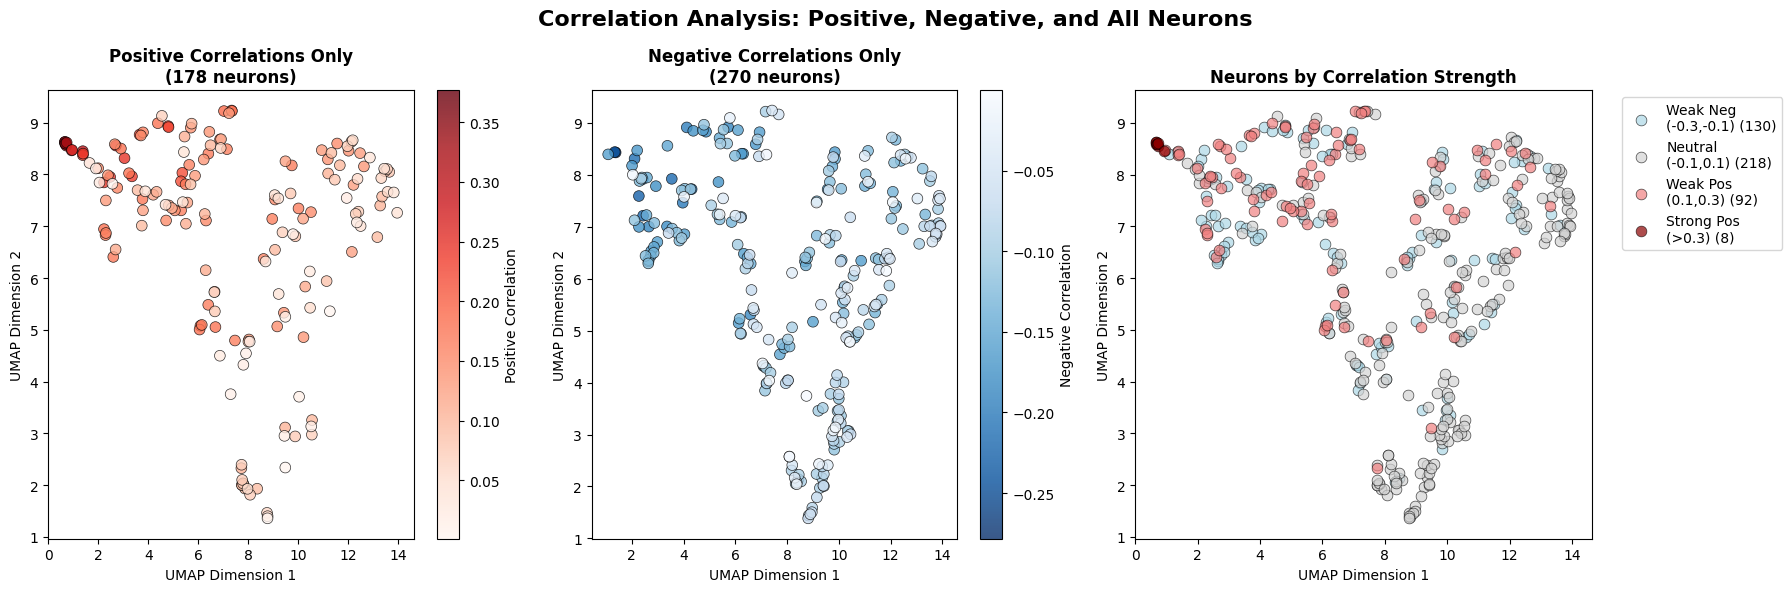


=== Detailed Correlation Statistics ===
Weak Neg
(-0.3,-0.1): 130 neurons (mean: -0.1397)
Neutral
(-0.1,0.1): 218 neurons (mean: -0.0190)
Weak Pos
(0.1,0.3): 92 neurons (mean: 0.1584)
Strong Pos
(>0.3): 8 neurons (mean: 0.3432)

Overall statistics:
Mean correlation: -0.0112
Std correlation: 0.1247
Median correlation: -0.0452


In [32]:
# Create focused plots for different correlation ranges
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle('Correlation Analysis: Positive, Negative, and All Neurons', fontsize=16, fontweight='bold')

# Plot 1: Only positive correlations
ax1 = axes[0]
positive_mask = neuron_metadata_df['correlation'] > 0
if positive_mask.sum() > 0:
    scatter1 = ax1.scatter(neuron_metadata_df.loc[positive_mask, 'umap_x'], 
                          neuron_metadata_df.loc[positive_mask, 'umap_y'],
                          c=neuron_metadata_df.loc[positive_mask, 'correlation'], 
                          cmap='Reds', s=60, alpha=0.8, edgecolors='black', linewidth=0.5)
    ax1.set_title(f'Positive Correlations Only\n({positive_mask.sum()} neurons)', fontweight='bold')
    cbar1 = plt.colorbar(scatter1, ax=ax1)
    cbar1.set_label('Positive Correlation')
else:
    ax1.set_title('No Positive Correlations Found')
ax1.set_xlabel('UMAP Dimension 1')
ax1.set_ylabel('UMAP Dimension 2')

# Plot 2: Only negative correlations  
ax2 = axes[1]
negative_mask = neuron_metadata_df['correlation'] < 0
if negative_mask.sum() > 0:
    scatter2 = ax2.scatter(neuron_metadata_df.loc[negative_mask, 'umap_x'], 
                          neuron_metadata_df.loc[negative_mask, 'umap_y'],
                          c=neuron_metadata_df.loc[negative_mask, 'correlation'], 
                          cmap='Blues_r', s=60, alpha=0.8, edgecolors='black', linewidth=0.5)
    ax2.set_title(f'Negative Correlations Only\n({negative_mask.sum()} neurons)', fontweight='bold')
    cbar2 = plt.colorbar(scatter2, ax=ax2)
    cbar2.set_label('Negative Correlation')
else:
    ax2.set_title('No Negative Correlations Found')
ax2.set_xlabel('UMAP Dimension 1')
ax2.set_ylabel('UMAP Dimension 2')

# Plot 3: Correlation intensity binned
ax3 = axes[2]
# Create correlation bins
correlation_bins = [-1, -0.3, -0.1, 0.1, 0.3, 1]
colors = ['darkblue', 'lightblue', 'lightgray', 'lightcoral', 'darkred']
bin_labels = ['Strong Neg\n(<-0.3)', 'Weak Neg\n(-0.3,-0.1)', 'Neutral\n(-0.1,0.1)', 'Weak Pos\n(0.1,0.3)', 'Strong Pos\n(>0.3)']

for i in range(len(correlation_bins)-1):
    mask = (neuron_metadata_df['correlation'] >= correlation_bins[i]) & (neuron_metadata_df['correlation'] < correlation_bins[i+1])
    if mask.sum() > 0:
        ax3.scatter(neuron_metadata_df.loc[mask, 'umap_x'], 
                   neuron_metadata_df.loc[mask, 'umap_y'],
                   c=colors[i], label=f'{bin_labels[i]} ({mask.sum()})', 
                   s=60, alpha=0.7, edgecolors='black', linewidth=0.5)

ax3.set_title('Neurons by Correlation Strength', fontweight='bold')
ax3.set_xlabel('UMAP Dimension 1')
ax3.set_ylabel('UMAP Dimension 2')
ax3.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

# Print detailed statistics
print("\n=== Detailed Correlation Statistics ===")
for i in range(len(correlation_bins)-1):
    mask = (neuron_metadata_df['correlation'] >= correlation_bins[i]) & (neuron_metadata_df['correlation'] < correlation_bins[i+1])
    count = mask.sum()
    if count > 0:
        mean_corr = neuron_metadata_df.loc[mask, 'correlation'].mean()
        print(f"{bin_labels[i]}: {count} neurons (mean: {mean_corr:.4f})")
        
print(f"\nOverall statistics:")
print(f"Mean correlation: {neuron_metadata_df['correlation'].mean():.4f}")
print(f"Std correlation: {neuron_metadata_df['correlation'].std():.4f}")
print(f"Median correlation: {neuron_metadata_df['correlation'].median():.4f}")

### Interactive Correlation Analysis

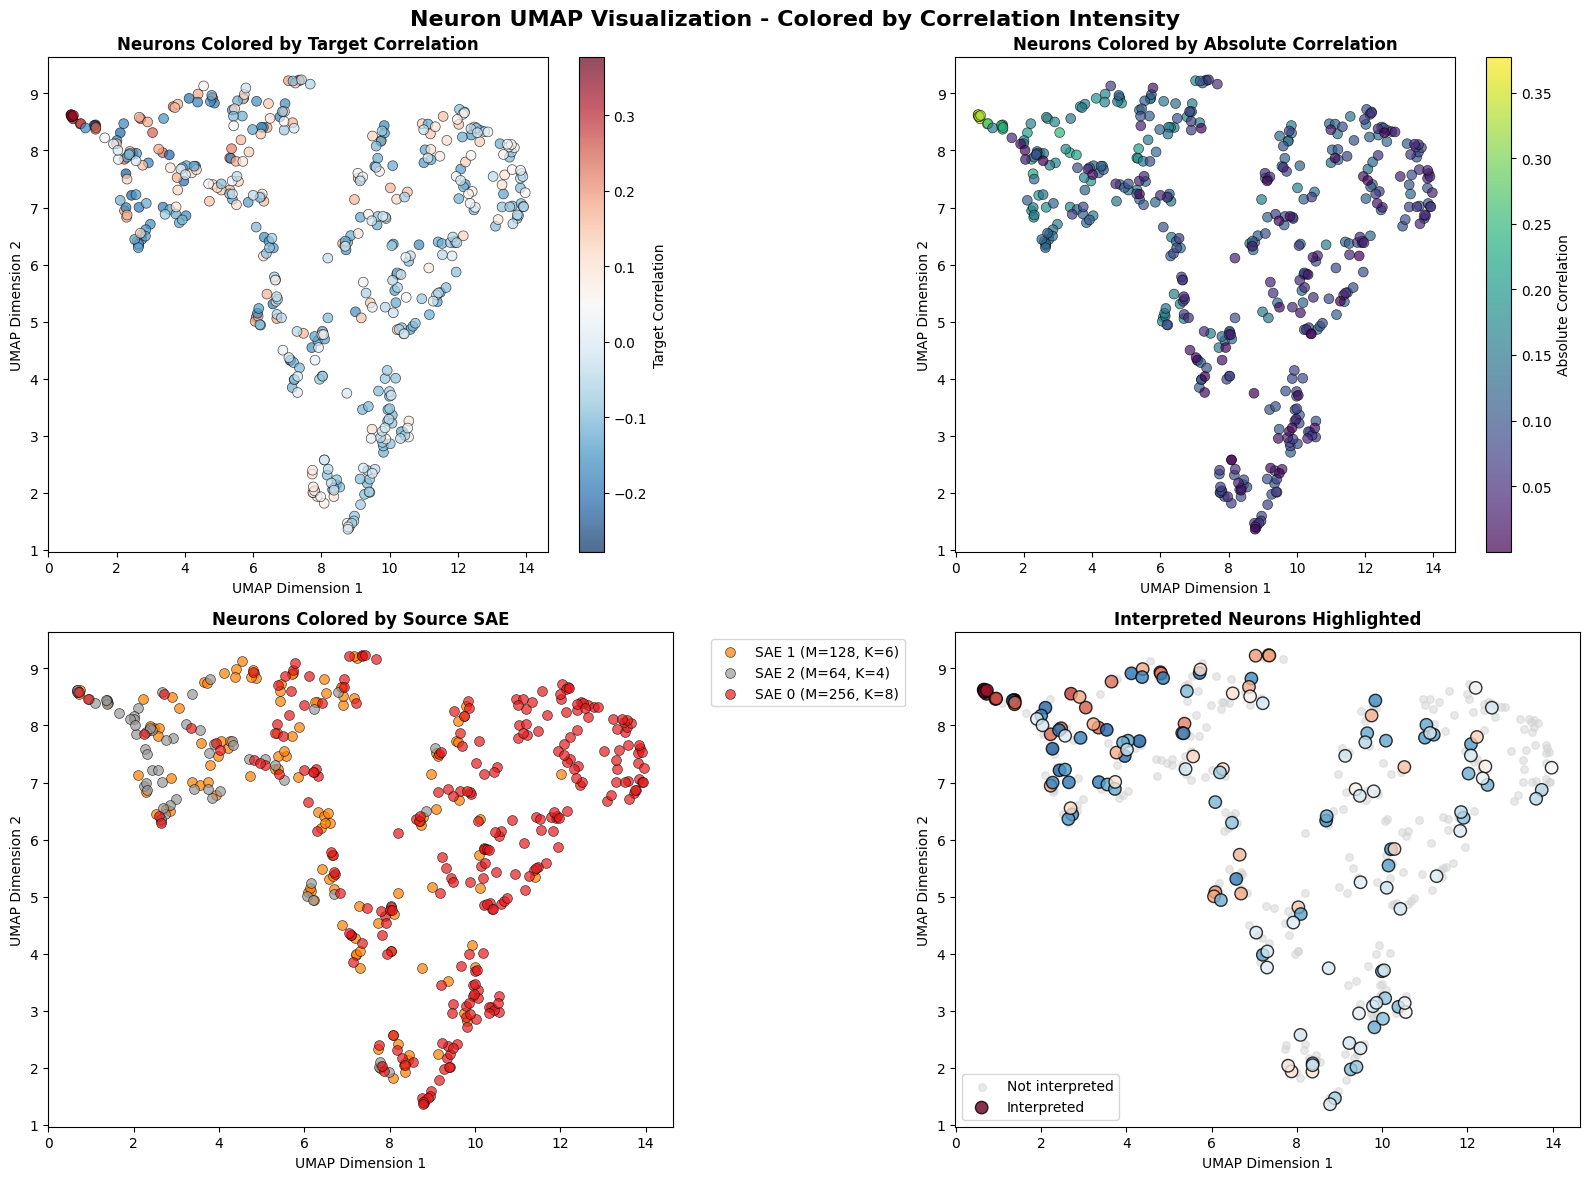


=== UMAP Visualization Summary ===
Total neurons visualized: 448
Interpreted neurons highlighted: 150
Correlation range: -0.2783 to 0.3768
UMAP spread - X: 0.66 to 13.97
UMAP spread - Y: 1.36 to 9.24


In [33]:
# Create comprehensive visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Neuron UMAP Visualization - Colored by Correlation Intensity', fontsize=16, fontweight='bold')

# Plot 1: Correlation intensity (continuous colormap)
ax1 = axes[0, 0]
scatter1 = ax1.scatter(neuron_metadata_df['umap_x'], neuron_metadata_df['umap_y'], 
                      c=neuron_metadata_df['correlation'], 
                      cmap='RdBu_r', s=50, alpha=0.7, edgecolors='black', linewidth=0.5)
ax1.set_title('Neurons Colored by Target Correlation', fontweight='bold')
ax1.set_xlabel('UMAP Dimension 1')
ax1.set_ylabel('UMAP Dimension 2')
cbar1 = plt.colorbar(scatter1, ax=ax1)
cbar1.set_label('Target Correlation')

# Plot 2: Absolute correlation intensity
ax2 = axes[0, 1]
scatter2 = ax2.scatter(neuron_metadata_df['umap_x'], neuron_metadata_df['umap_y'], 
                      c=neuron_metadata_df['abs_correlation'], 
                      cmap='viridis', s=50, alpha=0.7, edgecolors='black', linewidth=0.5)
ax2.set_title('Neurons Colored by Absolute Correlation', fontweight='bold')
ax2.set_xlabel('UMAP Dimension 1')
ax2.set_ylabel('UMAP Dimension 2')
cbar2 = plt.colorbar(scatter2, ax=ax2)
cbar2.set_label('Absolute Correlation')

# Plot 3: SAE membership
ax3 = axes[1, 0]
colors = plt.cm.Set1(np.linspace(0, 1, len(SAE_CONFIGS)))
for sae_idx in neuron_metadata_df['sae_idx'].unique():
    mask = neuron_metadata_df['sae_idx'] == sae_idx
    sae_config = SAE_CONFIGS[sae_idx]
    label = f'SAE {sae_idx} (M={sae_config[0]}, K={sae_config[1]})'
    ax3.scatter(neuron_metadata_df.loc[mask, 'umap_x'], 
               neuron_metadata_df.loc[mask, 'umap_y'],
               c=[colors[sae_idx]], label=label, s=50, alpha=0.7, 
               edgecolors='black', linewidth=0.5)
ax3.set_title('Neurons Colored by Source SAE', fontweight='bold')
ax3.set_xlabel('UMAP Dimension 1')
ax3.set_ylabel('UMAP Dimension 2')
ax3.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Plot 4: Interpreted vs non-interpreted neurons
ax4 = axes[1, 1]
interpreted_mask = neuron_metadata_df['is_interpreted']
ax4.scatter(neuron_metadata_df.loc[~interpreted_mask, 'umap_x'], 
           neuron_metadata_df.loc[~interpreted_mask, 'umap_y'],
           c='lightgray', label='Not interpreted', s=30, alpha=0.5)
ax4.scatter(neuron_metadata_df.loc[interpreted_mask, 'umap_x'], 
           neuron_metadata_df.loc[interpreted_mask, 'umap_y'],
           c=neuron_metadata_df.loc[interpreted_mask, 'correlation'], 
           cmap='RdBu_r', label='Interpreted', s=80, alpha=0.8,
           edgecolors='black', linewidth=1)
ax4.set_title('Interpreted Neurons Highlighted', fontweight='bold')
ax4.set_xlabel('UMAP Dimension 1')
ax4.set_ylabel('UMAP Dimension 2')
ax4.legend()

plt.tight_layout()
plt.show()

print(f"\n=== UMAP Visualization Summary ===")
print(f"Total neurons visualized: {len(neuron_metadata_df)}")
print(f"Interpreted neurons highlighted: {neuron_metadata_df['is_interpreted'].sum()}")
print(f"Correlation range: {neuron_metadata_df['correlation'].min():.4f} to {neuron_metadata_df['correlation'].max():.4f}")
print(f"UMAP spread - X: {neuron_metadata_df['umap_x'].min():.2f} to {neuron_metadata_df['umap_x'].max():.2f}")
print(f"UMAP spread - Y: {neuron_metadata_df['umap_y'].min():.2f} to {neuron_metadata_df['umap_y'].max():.2f}")

✓ Saved visualization data to: ../outputs/Multiple_SAEs_depressiontext-embedding-3-small/neuron_visualization_data.csv

Creating high-resolution plots...


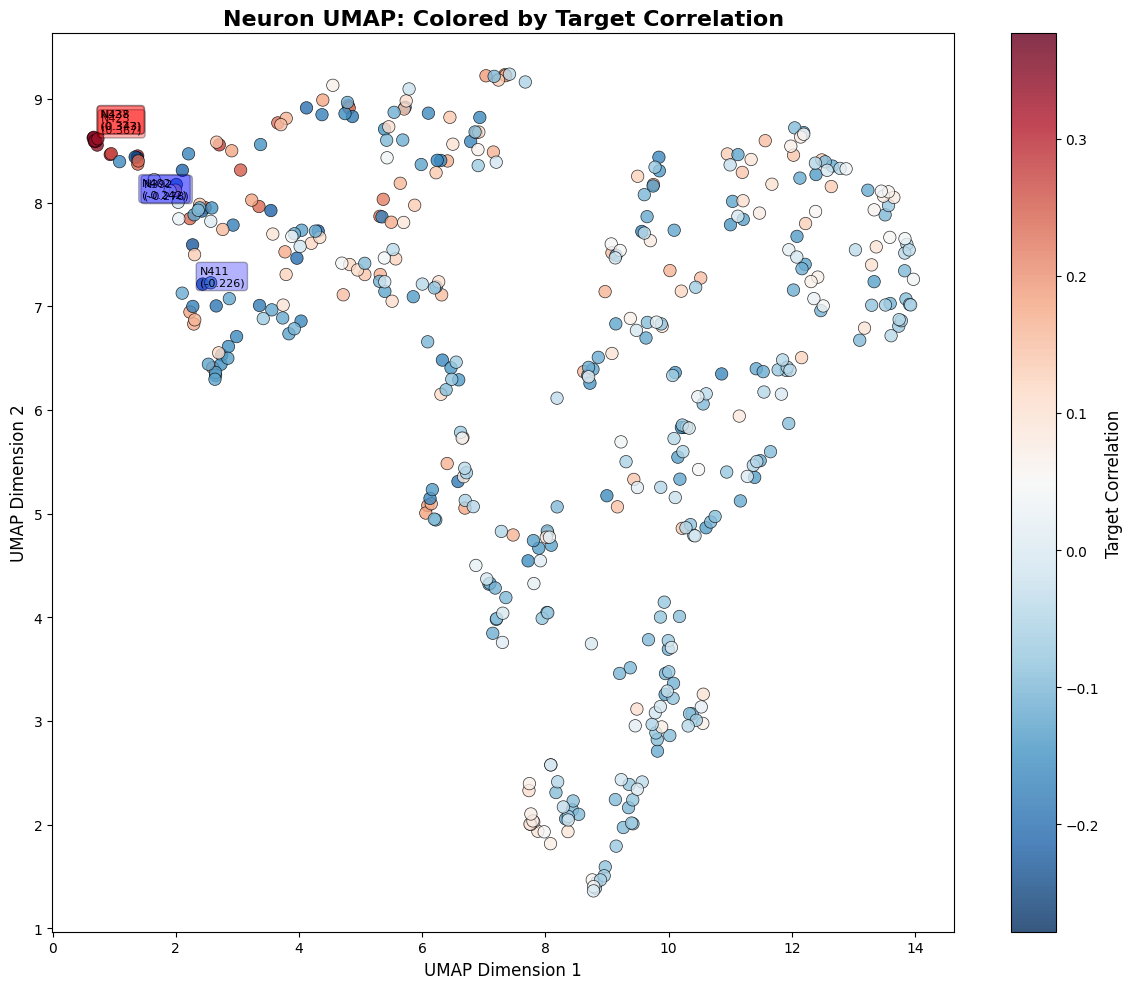

✓ Saved main correlation plot to: ../outputs/Multiple_SAEs_depressiontext-embedding-3-small/neuron_umap_correlation.png


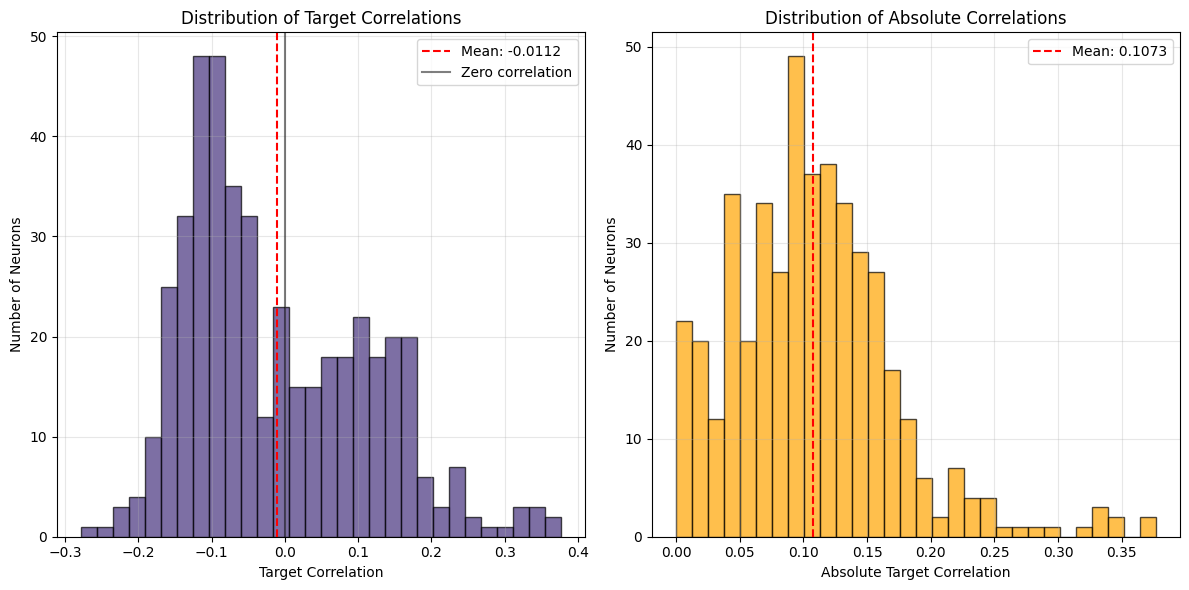

✓ Saved correlation distribution plot to: ../outputs/Multiple_SAEs_depressiontext-embedding-3-small/correlation_distribution.png

✓ Visualization module complete!
All visualization files saved to: ../outputs/Multiple_SAEs_depressiontext-embedding-3-small
Files created:
- neuron_visualization_data.csv (UMAP coordinates and metadata)
- neuron_umap_correlation.png (main correlation plot)
- correlation_distribution.png (correlation histograms)


In [34]:
# Save visualization data and create additional plots
visualization_data_path = os.path.join(output_dir, "neuron_visualization_data.csv")
neuron_metadata_df.to_csv(visualization_data_path, index=False)
print(f"✓ Saved visualization data to: {visualization_data_path}")

# Create and save high-resolution plots
print("\nCreating high-resolution plots...")

# Main correlation plot
plt.figure(figsize=(12, 10))
scatter = plt.scatter(neuron_metadata_df['umap_x'], neuron_metadata_df['umap_y'], 
                     c=neuron_metadata_df['correlation'], 
                     cmap='RdBu_r', s=80, alpha=0.8, edgecolors='black', linewidth=0.5)
plt.title('Neuron UMAP: Colored by Target Correlation', fontsize=16, fontweight='bold')
plt.xlabel('UMAP Dimension 1', fontsize=12)
plt.ylabel('UMAP Dimension 2', fontsize=12)
cbar = plt.colorbar(scatter)
cbar.set_label('Target Correlation', fontsize=12)

# Add annotations for most extreme correlations
top_positive = neuron_metadata_df.nlargest(3, 'correlation')
top_negative = neuron_metadata_df.nsmallest(3, 'correlation')

for _, row in top_positive.iterrows():
    plt.annotate(f"N{row['neuron_idx']}\n({row['correlation']:.3f})", 
                (row['umap_x'], row['umap_y']), 
                xytext=(5, 5), textcoords='offset points',
                fontsize=8, ha='left', va='bottom',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='red', alpha=0.3))

for _, row in top_negative.iterrows():
    plt.annotate(f"N{row['neuron_idx']}\n({row['correlation']:.3f})", 
                (row['umap_x'], row['umap_y']), 
                xytext=(5, -15), textcoords='offset points',
                fontsize=8, ha='left', va='top',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='blue', alpha=0.3))

plt.tight_layout()
plot_path = os.path.join(output_dir, "neuron_umap_correlation.png")
plt.savefig(plot_path, dpi=300, bbox_inches='tight')
plt.show()
print(f"✓ Saved main correlation plot to: {plot_path}")

# Create correlation distribution plot
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(neuron_metadata_df['correlation'], bins=30, alpha=0.7, edgecolor='black')
plt.axvline(neuron_metadata_df['correlation'].mean(), color='red', linestyle='--', 
           label=f'Mean: {neuron_metadata_df["correlation"].mean():.4f}')
plt.axvline(0, color='black', linestyle='-', alpha=0.5, label='Zero correlation')
plt.xlabel('Target Correlation')
plt.ylabel('Number of Neurons')
plt.title('Distribution of Target Correlations')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.hist(neuron_metadata_df['abs_correlation'], bins=30, alpha=0.7, edgecolor='black', color='orange')
plt.axvline(neuron_metadata_df['abs_correlation'].mean(), color='red', linestyle='--', 
           label=f'Mean: {neuron_metadata_df["abs_correlation"].mean():.4f}')
plt.xlabel('Absolute Target Correlation')
plt.ylabel('Number of Neurons')
plt.title('Distribution of Absolute Correlations')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
dist_plot_path = os.path.join(output_dir, "correlation_distribution.png")
plt.savefig(dist_plot_path, dpi=300, bbox_inches='tight')
plt.show()
print(f"✓ Saved correlation distribution plot to: {dist_plot_path}")

print(f"\n✓ Visualization module complete!")
print(f"All visualization files saved to: {output_dir}")
print(f"Files created:")
print(f"- neuron_visualization_data.csv (UMAP coordinates and metadata)")
print(f"- neuron_umap_correlation.png (main correlation plot)")
print(f"- correlation_distribution.png (correlation histograms)")